In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
#from tsfresh import extract_features, impute
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

100%|██████████| 20/20 [08:37<00:00, 25.88s/trial, best loss: 2.85912120976228]  
Root Mean Square Error (RMSE): 2.85912120976228
       Actual Values  Predicted Values
0          22.100000         22.386740
1          19.799999         21.381012
2          23.600000         22.760618
3          22.100000         22.022015
4          22.100000         20.910036
...              ...               ...
80977      19.200001         20.563622
80978      22.200000         22.524492
80979      26.600000         23.911810
80980      19.200001         21.107914
80981      22.200000         22.270702

[80982 rows x 2 columns]


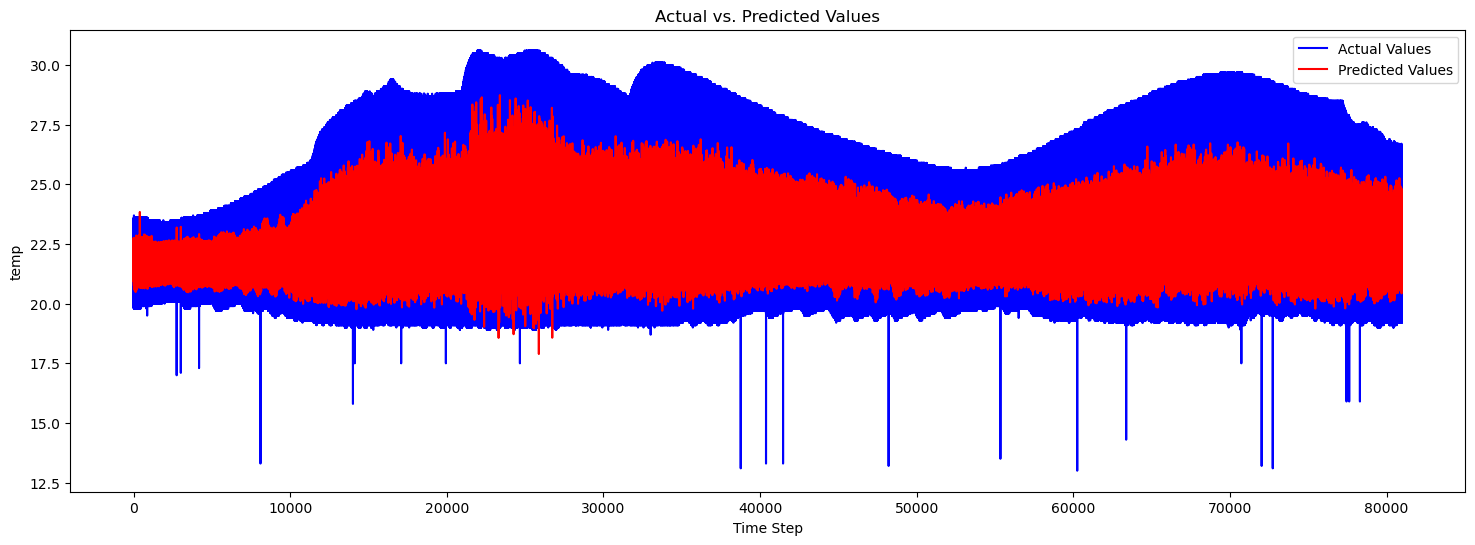

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Define hyperparameter search space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

def upload_sensor_data():
    """Download sensor data."""
    sensor_data = pd.read_csv('C:/Users/ankus/sensor.csv')
    sensor_data = sensor_data.drop(['motion'], axis=1) #it only has false values
    label_encoder = LabelEncoder()
    sensor_data['device'] = label_encoder.fit_transform(sensor_data['device'])
    sensor_data['light'] = label_encoder.fit_transform(sensor_data['light'])
    sensor_data = sensor_data.drop(['lpg', 'smoke', 'co', 'ts'], axis=1) #high correlation
    return sensor_data

def prepare_data(sensor_data, target_column='temp', n_steps=60):
    """Prepare data for time series prediction."""
    target_values = sensor_data[target_column].values

    X, y = [], []

    for i in range(len(target_values) - n_steps):
        X.append(target_values[i:i + n_steps])
        y.append(target_values[i + n_steps])

    X = np.array(X)
    y = np.array(y)

    return X, y

def remove_outliers(y_test, y_pred, threshold=3):
    """Remove outliers based on Z-score."""
    z_scores = np.abs(stats.zscore(y_test))
    y_test_no_outliers = y_test[z_scores <= threshold]
    y_pred_no_outliers = y_pred[z_scores <= threshold]
    return y_test_no_outliers, y_pred_no_outliers

def objective(params):
    """Objective function for Hyperopt to minimize."""
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    learning_rate = params['learning_rate']
    min_child_weight = int(params['min_child_weight'])
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']
    target_column = 'temp'  
    n_steps = 60  # The number of time steps

    # Build the XGBoost model with the given hyperparameters
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='reg:squarederror'
    )

    # Split data using rolling window approach
    sensor_data = upload_sensor_data() 
    X, y = prepare_data(sensor_data, target_column, n_steps)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Remove outliers
    y_test_no_outliers, y_pred_no_outliers = remove_outliers(y_test, y_pred)

    # Calculate RMSE without outliers
    rmse_no_outliers = np.sqrt(mean_squared_error(y_test_no_outliers, y_pred_no_outliers))

    return {'loss': rmse_no_outliers, 'status': STATUS_OK}

def main():
    target_column = 'temp'

    # Define Hyperopt optimization algorithm
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Retrieve best hyperparameters
    best_n_estimators = int(best['n_estimators'])
    best_max_depth = int(best['max_depth'])
    best_learning_rate = best['learning_rate']
    best_min_child_weight = int(best['min_child_weight'])
    best_subsample = best['subsample']
    best_colsample_bytree = best['colsample_bytree']

    # Build and train the final model with the best hyperparameters
    final_model = xgb.XGBRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        learning_rate=best_learning_rate,
        min_child_weight=best_min_child_weight,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        objective='reg:squarederror'
    )
    
    sensor_data = upload_sensor_data() 
    n_steps = 60 
    X, y = prepare_data(sensor_data, target_column, n_steps)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    final_model.fit(X_train, y_train)

    # Make predictions
    y_pred = final_model.predict(X_test)

    # Remove outliers
    y_test_no_outliers, y_pred_no_outliers = remove_outliers(y_test, y_pred)

    # Calculate RMSE without outliers
    rmse_no_outliers = np.sqrt(mean_squared_error(y_test_no_outliers, y_pred_no_outliers))

    print(f"Root Mean Square Error (RMSE): {rmse_no_outliers}")
    result_df = pd.DataFrame({'Actual Values': y_test_no_outliers, 'Predicted Values': y_pred_no_outliers})
    print(result_df)

    # Visualize actual vs. predicted values without outliers
    plt.figure(figsize=(18, 6))
    plt.plot(y_test_no_outliers, label='Actual Values', color='blue')
    plt.plot(y_pred_no_outliers, label='Predicted Values', color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
